In [1]:
# Imports and helpers (simple version; assumes CSV columns are SNR, FER, BER)
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections

try:
    from scipy.interpolate import PchipInterpolator as _PCHIP
    PCHIP_AVAILABLE = True
except Exception:
    _PCHIP = None
    PCHIP_AVAILABLE = False

C:\Users\asus\AppData\Local\Temp\ipykernel_43840\1808881655.py:9: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import PchipInterpolator as _PCHIP


In [2]:
def parse_filename(path):
    """Extract Name and CodeType from filenames like 'Name_CodeType.csv'.
       Splits on the last underscore; if no underscore, CodeType set to 'unknown'."""
    base = os.path.splitext(os.path.basename(path))[0]
    if "_" in base:
        name, code = base.rsplit("_", 1)
    else:
        name, code = base, "unknown"
    return name, code

# scan CSV files
csv_files = sorted(glob.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files in the working directory.")
for f in csv_files[:1000]:
    print(" -", f)


Found 4 CSV files in the working directory.
 - GDBF_PEGReg504x1008.csv
 - MethodA_PEGReg504x1008.csv
 - NGDBF_PEGReg504x1008.csv
 - UPGDBF_PEGReg504x1008.csv


In [3]:
def read_csv_simple(path, *, truncate_on_zero=True, zero_tol=0.0):
    """
    Read CSV that contains SNR, FER, BER (either as headers 'SNR','FER','BER' or in that column order).
    Returns DataFrame with columns: snr, fer, ber (floats).
    If truncate_on_zero is True, then upon encountering the first row where (fer == 0 AND ber == 0)
    that row and all subsequent rows are removed from the returned DataFrame.

    zero_tol: float tolerance for treating a value as zero (useful if values are near-zero floats).
    """
    df = pd.read_csv(path)
    # allow header names in any case and with surrounding whitespace; fall back to column positions
    cols = {c.strip().lower(): c for c in df.columns}
    snr_col = cols.get('snr', df.columns[0])
    fer_col = cols.get('fer', df.columns[1])
    ber_col = cols.get('ber', df.columns[2])

    # convert to numeric (non-numeric -> NaN)
    snr = pd.to_numeric(df[snr_col], errors='coerce').astype(float)
    fer = pd.to_numeric(df[fer_col], errors='coerce').astype(float)
    ber = pd.to_numeric(df[ber_col], errors='coerce').astype(float)

    out = pd.DataFrame({'snr': snr, 'fer': fer, 'ber': ber})

    if truncate_on_zero:
        if zero_tol == 0.0:
            mask = (out['fer'] == 0) & (out['ber'] == 0)
        else:
            mask = (out['fer'].abs() <= zero_tol) & (out['ber'].abs() <= zero_tol)
        # 找第一個滿足條件的 index
        zero_idxs = np.nonzero(mask.to_numpy())[0]  # array of indices
        if zero_idxs.size > 0:
            first_zero_idx = int(zero_idxs[0])
            out = out.iloc[:first_zero_idx].reset_index(drop=True)

    return out

In [4]:

# Build dataset grouped by CodeType
files = sorted([f for f in glob.glob("*.csv")])
grouped = collections.defaultdict(list)

for f in files:
    name, code = parse_filename(f)
    df = read_csv_simple(f, truncate_on_zero=True, zero_tol=0.0)  # 若需要容差可設例如 1e-12
    if df.empty:
        continue
    grouped[code].append((name, df))

print("\nGrouped files by CodeType:")
for c, items in grouped.items():
    print(f"CodeType: {c}, files: {[n for n,_ in items]}")



Grouped files by CodeType:
CodeType: PEGReg504x1008, files: ['GDBF', 'MethodA', 'NGDBF', 'UPGDBF']


In [5]:
def get_interpolator(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    valid = ~np.isnan(ys)
    xs = xs[valid]; ys = ys[valid]
    if len(xs) == 0:
        return None
    if len(xs) == 1:
        return lambda xx: np.full_like(xx, ys[0], dtype=float)
    if PCHIP_AVAILABLE and _PCHIP is not None:
        try:
            ip = _PCHIP(xs, ys, extrapolate=False)
            return lambda xx: ip(xx)
        except Exception:
            pass
    # fallback linear interpolation

In [6]:
def _to_numeric_and_sort(df, snr_col='snr', metric_col='ber'):
    """Ensure numeric, drop rows missing snr/metric, sort by snr."""
    df = df.copy()
    df[snr_col] = pd.to_numeric(df[snr_col], errors='coerce')
    df[metric_col] = pd.to_numeric(df[metric_col], errors='coerce')
    df = df.dropna(subset=[snr_col, metric_col])
    df = df.sort_values(snr_col).reset_index(drop=True)
    return df

def plot_metric_for_grouped(grouped,
                            metric='ber',
                            out_dir='.',
                            logy=True,
                            xlim=None,  # e.g. (2.0, 7.0) or None
                            ylim=None,  # e.g. (1e-7, 1.0) for logy or (0,1) for linear
                            min_y_eps=1e-12,  # used only if zero_policy == 'eps'
                            zero_policy='mask',  # 'mask' -> keep zeros as NaN; 'eps' -> replace <=0 by eps
                            figsize=(8,5),
                            marker_size=20,
                            dpi=200):
    """
    Plot metric ('ber' or 'fer') for each code in grouped (grouped: code -> list of (name, df)).
    Returns list of saved file paths.
    """
    os.makedirs(out_dir, exist_ok=True)
    saved = []

    for code, items in grouped.items():
        if not items:
            continue

        # determine combined x domain for plotting (if xlim not given)
        all_snrs = np.concatenate([np.array(it[1]['snr'].values, dtype=float) for it in items if (it[1] is not None and len(it[1])>0)])
        if xlim is None:
            domain_min, domain_max = float(np.nanmin(all_snrs)), float(np.nanmax(all_snrs))
        else:
            domain_min, domain_max = float(xlim[0]), float(xlim[1])

        # Build one figure per metric per code
        plt.figure(figsize=figsize)
        first_label = True
        for name, df in items:
            if df is None or df.empty:
                continue
            # normalize column names tolerant to different column labels
            # ensure df has 'snr' and metric column names; if not, try to detect
            tmp = df.copy()
            # convert column names to lower for detection
            colmap = {c.lower(): c for c in tmp.columns}
            snr_col = colmap.get('snr', tmp.columns[0])
            metric_col = colmap.get(metric.lower(), tmp.columns[1] if metric.lower() != 'snr' else tmp.columns[1])

            # numeric + sort
            tmp = _to_numeric_and_sort(tmp, snr_col=snr_col, metric_col=metric_col)

            if tmp.empty:
                continue

            xs = tmp[snr_col].to_numpy(dtype=float)
            ys = tmp[metric_col].to_numpy(dtype=float)

            # handle zeros/negatives for log scale
            if logy:
                if zero_policy == 'mask':
                    # mask (set to NaN) any non-positive values -> matplotlib will break line there
                    ys = np.where(ys > 0, ys, np.nan)
                elif zero_policy == 'eps':
                    ys = np.where(ys > 0, ys, min_y_eps)
                else:
                    raise ValueError("zero_policy must be 'mask' or 'eps'")

            # drop rows where xs or ys are nan after processing
            valid_mask = np.isfinite(xs) & np.isfinite(ys)
            if not valid_mask.any():
                continue
            xs_valid = xs[valid_mask]
            ys_valid = ys[valid_mask]

            # scatter actual points
            label = name if first_label else name  # keep label for each segment (you can change to only label first)
            plt.scatter(xs_valid, ys_valid, s=marker_size, label=name)

            # connect points with a simple line (sorted already)
            # If you used 'mask' and ys has NaN in middle, this line will not connect over the NaNs
            plt.plot(xs_valid, ys_valid, linestyle='-', linewidth=1)

            first_label = False

        # axis and formatting
        plt.xlabel("SNR (dB)")
        plt.ylabel(metric.upper())
        plt.title(f"SNR vs {metric.upper()} — CodeType: {code}")

        if logy:
            plt.yscale('log')
            # default ylim if none provided: top=1.0 bottom = small positive (if using mask, bottom must be >0)
            if ylim is None:
                # compute min positive y across items to set bottom (avoid zero)
                all_ypos = []
                for _, df in items:
                    if df is None or df.empty: continue
                    colmap = {c.lower(): c for c in df.columns}
                    mcol = colmap.get(metric.lower(), None)
                    if mcol:
                        arr = pd.to_numeric(df[mcol], errors='coerce').to_numpy(dtype=float)
                        all_ypos.extend(arr[arr > 0].tolist())
                if all_ypos:
                    bottom = max(min(all_ypos) / 10.0, min_y_eps)  # a decade below smallest positive (but not < eps)
                else:
                    bottom = min_y_eps
                top = 1.0
                plt.ylim(bottom=bottom, top=top)
            else:
                plt.ylim(bottom=ylim[0], top=ylim[1])
        else:
            if ylim is not None:
                plt.ylim(ylim[0], ylim[1])

        if xlim is not None:
            plt.xlim(xlim[0], xlim[1])
        else:
            plt.xlim(domain_min, domain_max)

        plt.legend(fontsize='small', loc='best')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        outp = os.path.join(out_dir, f"snr_{metric}_{code}.png")
        plt.tight_layout()
        plt.savefig(outp, dpi=dpi)
        saved.append(outp)
        plt.show()
        plt.close()

    return saved


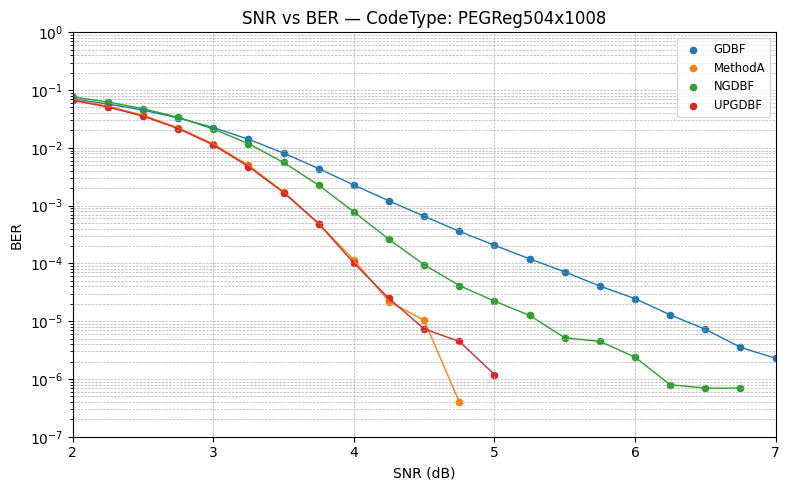

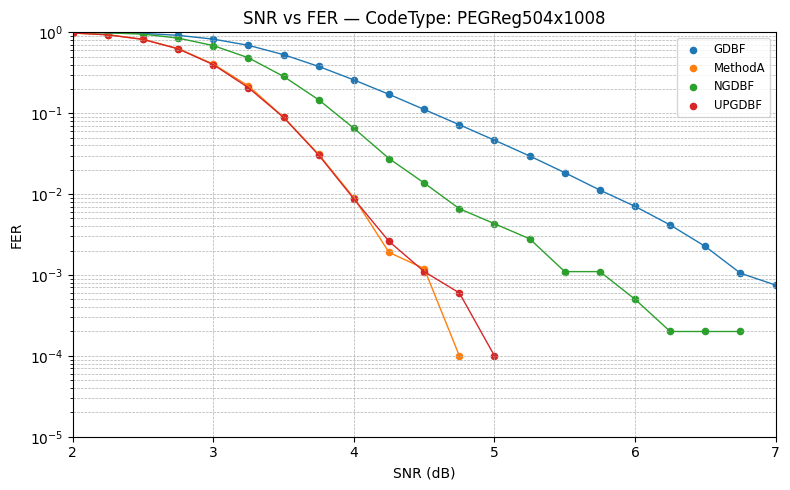

Saved plots:
 - plots\snr_ber_PEGReg504x1008.png
 - plots\snr_fer_PEGReg504x1008.png


In [7]:
# 假設 grouped 變數跟你原來一樣 (code -> list of (name, df))
# 畫 BER（log y）
saved_files = plot_metric_for_grouped(
    grouped,
    metric='ber',
    out_dir='plots',
    logy=True,
    xlim=(2.0, 7.0),
    ylim=(1e-7, 1.0),        # optional; 若 None 則自動選擇合理下界
    zero_policy='mask',     # 'mask' (預設) or 'eps'（若想在 log 上視覺連線）
)

# 畫 FER（也可用 logy True/False 視需求）
saved_files += plot_metric_for_grouped(
    grouped,
    metric='fer',
    out_dir='plots',
    logy=True,
    xlim=(2.0, 7.0),
    zero_policy='mask'
)

print("Saved plots:")
for p in saved_files:
    print(" -", p)